In [13]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder


# Load the Banknote Authentication dataset
data = fetch_openml('banknote-authentication')
X = data.data
y = data.target

# Convert the string labels to integers
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    exps = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exps / (np.sum(exps, axis=0, keepdims=True) + 1e-10)

def softmax_derivative(x):
    p = softmax(x)
    return p * (1 - p)

def hidden_activation(x, k0, k1):
    return k0 + k1 * x

def hidden_activation_derivative(x, k0, k1):
    return k1

n_i = X_train.shape[1]  # Number of inputs
n_o = len(np.unique(y))  # Number of outputs

avg_train_f1_scores = []

learning_rate = 0.21

hidden_layer_sizes = [5, 10, 30, 60, 90, 100, 110]
kf = KFold(n_splits=3)

# Initialize the best scores and the corresponding number of hidden nodes
best_train_f1 = -np.inf
best_train_accuracy = -np.inf
best_test_f1 = -np.inf
best_test_accuracy = -np.inf
best_n_h = None
best_model = None

# Iterate over the different numbers of nodes in the hidden layer
for n_h in hidden_layer_sizes:
    f1_scores = []
    train_accuracies = []
    test_accuracies = [] 
    # y_train = y_train.to_numpy()

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        k0 = np.random.randn()
        k1 = np.random.randn()

        np.random.seed(42)
        W1 = np.random.randn(n_h, n_i)
        b1 = np.zeros(n_h)
        W2 = np.random.randn(n_o, n_h)
        b2 = np.zeros(n_o)

        for epoch in range(1000):
            Z1 = np.dot(W1, X_train_fold.T) + b1[:, None]
            A1 = hidden_activation(Z1, k0, k1)
            Z2 = np.dot(W2, A1) + b2[:, None]
            A2 = softmax(Z2)

            epsilon = 1e-7  # small constant
            A2_clipped = np.clip(A2, epsilon, 1 - epsilon)  # avoid extreme values
            loss = -np.mean(y_train_fold * np.log(A2_clipped))

            predictions_train = np.argmax(A2, axis=0)
            f1 = f1_score(y_train_fold, predictions_train, average="macro")

            f1_scores.append(f1)

        Z1 = np.dot(W1, X_val_fold.T) + b1[:, None]
        A1 = hidden_activation(Z1, k0, k1)
        Z2 = np.dot(W2, A1) + b2[:, None]
        A2 = softmax(Z2)
        predictions_val = np.argmax(A2, axis=0)

        f1_val = f1_score(y_val_fold, predictions_val, average="macro")
        accuracy_val = accuracy_score(y_val_fold, predictions_val)

        accuracy_train = accuracy_score(y_train_fold, predictions_train)

        f1_scores.append(f1_val)
        train_accuracies.append(accuracy_train)
        test_accuracies.append(accuracy_val)

    avg_train_f1 = np.mean(f1_scores)
    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_f1 = np.mean(f1_scores)
    avg_test_accuracy = np.mean(test_accuracies)

    avg_train_f1_scores.append(avg_train_f1)

    if avg_test_f1 > best_test_f1:
        best_train_f1 = avg_train_f1
        best_train_accuracy = avg_train_accuracy
        best_test_f1 = avg_test_f1
        best_test_accuracy = avg_test_accuracy
        best_n_h = n_h
        best_model = (W1, b1, W2, b2, k0, k1)  # Store the parameters of the best model


    print(f"\nNumber of nodes: {n_h}")
    print(f"Train F1-score: {avg_train_f1}")
    print(f"Train Accuracy: {avg_train_accuracy}")
    print(f"Validation F1-score: {avg_test_f1}")
    print(f"Validation Accuracy: {avg_test_accuracy}")

# Print the scores for the best model
print("\nBest model:")
print(f"Number of nodes: {best_n_h}")
print(f"Best Train F1-score: {best_train_f1}")
print(f"Best Train Accuracy: {best_train_accuracy}")
print(f"Best Test F1-score: {best_test_f1}")
print(f"Best Test Accuracy: {best_test_accuracy}")

/home/akshat_gosain/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(



Number of nodes: 5
Train F1-score: 0.5048560058924414
Train Accuracy: 0.509109959907206
Validation F1-score: 0.5048560058924414
Validation Accuracy: 0.5232776904458917

Number of nodes: 10
Train F1-score: 0.44920571914291074
Train Accuracy: 0.5569659049284983
Validation F1-score: 0.44920571914291074
Validation Accuracy: 0.5332435062504679

Number of nodes: 30
Train F1-score: 0.37569178889142807
Train Accuracy: 0.4093165287464586
Validation F1-score: 0.37569178889142807
Validation Accuracy: 0.41475409836065574

Number of nodes: 60
Train F1-score: 0.5104546420849783
Train Accuracy: 0.5132095664546159
Validation F1-score: 0.5104546420849783
Validation Accuracy: 0.5141677271252839

Number of nodes: 90
Train F1-score: 0.5729794911151888
Train Accuracy: 0.6034083858476672
Validation F1-score: 0.5729794911151888
Validation Accuracy: 0.603570626543903

Number of nodes: 100
Train F1-score: 0.4745530654631637
Train Accuracy: 0.49635514391294705
Validation F1-score: 0.4745530654631637
Validation

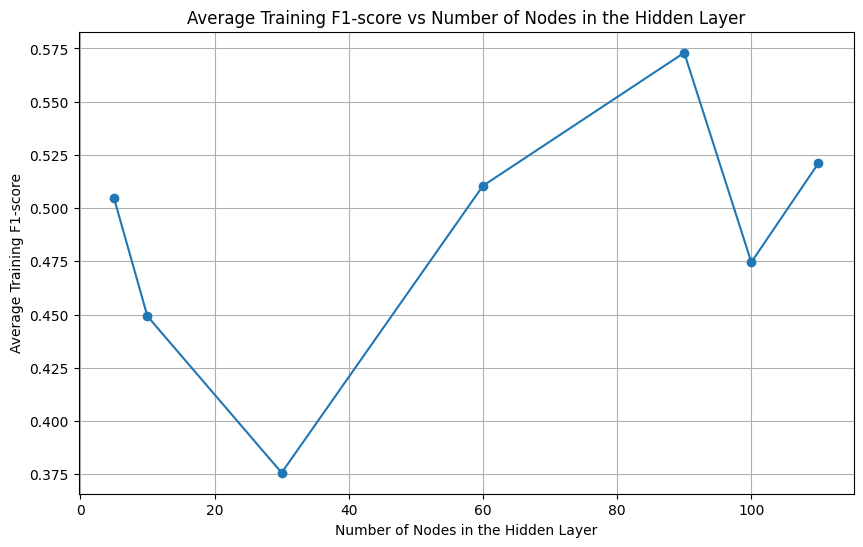

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_sizes, avg_train_f1_scores, marker='o')
plt.title('Average Training F1-score vs Number of Nodes in the Hidden Layer')
plt.xlabel('Number of Nodes in the Hidden Layer')
plt.ylabel('Average Training F1-score')
plt.grid(True)
plt.show()


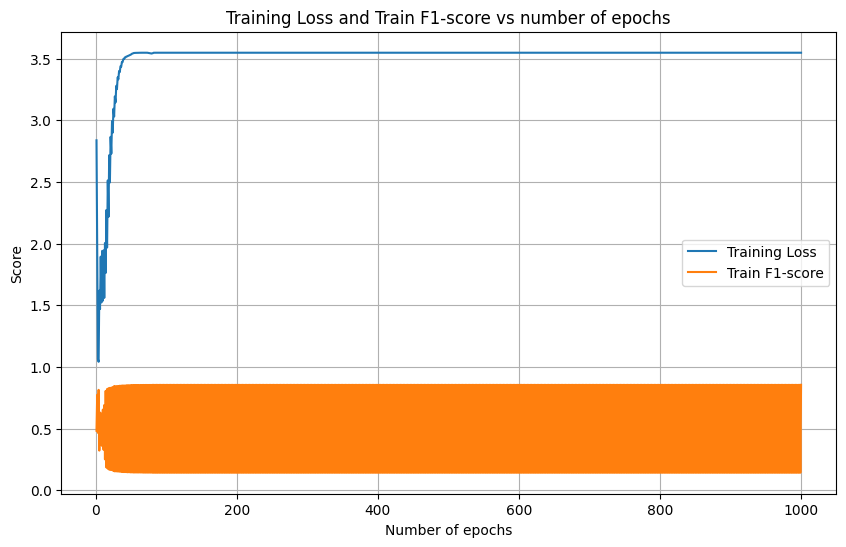

In [12]:
import matplotlib.pyplot as plt

# Initialize lists to store the training loss and F1-score for each epoch
train_losses = []
train_f1_scores = []

# Retrain the model with the entire training data using the best number of nodes in the hidden layer
k0 = np.random.randn()
k1 = np.random.randn()

np.random.seed(42)
W1 = np.random.randn(best_n_h, n_i)
b1 = np.zeros(best_n_h)
W2 = np.random.randn(n_o, best_n_h)
b2 = np.zeros(n_o)

for epoch in range(1000):
    Z1 = np.dot(W1, X_train.T) + b1[:, None]
    A1 = hidden_activation(Z1, k0, k1)
    Z2 = np.dot(W2, A1) + b2[:, None]
    A2 = softmax(Z2)

    epsilon = 1e-7  # small constant
    A2_clipped = np.clip(A2, epsilon, 1 - epsilon)  # avoid extreme values
    loss = -np.mean(y_train * np.log(A2_clipped))
    train_losses.append(loss)  # Store the training loss for this epoch

    predictions_train = np.argmax(A2, axis=0)
    f1 = f1_score(y_train, predictions_train, average="macro")
    train_f1_scores.append(f1)  # Store the training F1-score for this epoch

    dZ2 = A2 - y_train[None, :]
    dW2 = np.dot(dZ2, A1.T) / X_train.shape[0]
    db2 = np.sum(dZ2, axis=1) / X_train.shape[0]
    dZ1 = np.dot(W2.T, dZ2) * hidden_activation_derivative(Z1, k0, k1)
    dW1 = np.dot(dZ1, X_train) / X_train.shape[0]
    db1 = np.sum(dZ1, axis=1) / X_train.shape[0]

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

# Plot the training loss and F1-score for each epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), train_losses, label='Training Loss')
plt.plot(range(1, 1001), train_f1_scores, label='Train F1-score')
plt.title('Training Loss and Train F1-score vs number of epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
